# Shared Rides

My idea for a question is to explore shared rides (also called pooled trips). Some things I am wondering:

- Did shared trips become less common on ridesharing platforms during COVID?
- If shared trips dropped overall, did any community areas continue to use shared trips at a similar rate?

Data to answer this question comes from the [data portal rideshare trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p). Each row of the dataset is an individual trip and the dataset has this column:

**Trips Pooled (Number)**

> If customers were matched for a shared trip, how many trips, including this one, were pooled. All customer trips from the time the vehicle was empty until it was empty again contribute to this count, even if some customers were never present in the vehicle at the same time. Each trip making up the overall shared trip will have a separate record in this dataset, with the same value in this column.

In [3]:
import os
os.chdir("../../")

In [4]:
import pandas as pd
import requests
from timeit import default_timer as timer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
PORTAL_RIDESHARE_TRIPS = "https://data.cityofchicago.org/resource/m6dm-c72p.json"

First, I will write a query to find out how frequent pooled trips are.

In [37]:
query = """
SELECT
    trips_pooled,
    count(1) as count
GROUP BY trips_pooled
"""
start = timer()
r = requests.get(PORTAL_RIDESHARE_TRIPS, params={"$query": query})
df = pd.DataFrame(r.json())
secs = timer() - start
print(f"Fetched {len(df):,d} rows in {secs:.1f} secs.")

Fetched 23 rows in 0.6 secs.


In [38]:
df["trips_pooled"] = df["trips_pooled"].astype(int)
df["count"] = df["count"].astype(int)
df.head()

,trips_pooled,count
0,1,169311931
1,2,10805782
2,3,7065794
3,4,1677197
4,5,564758


I can plot a histogram (as a bar chart, since I have the counts already) to visualize the distribution.

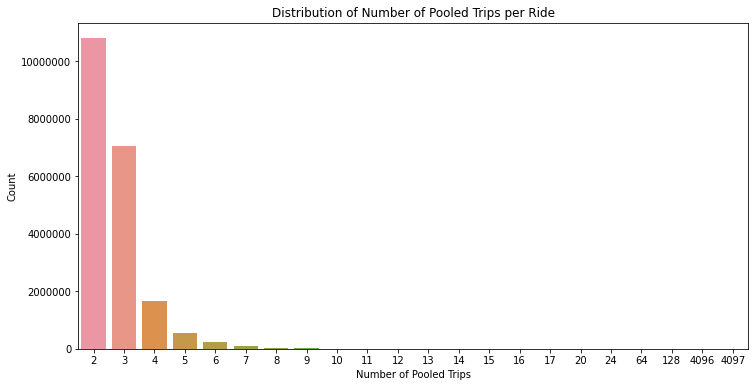

In [34]:
sns.barplot(data=df.query("trips_pooled > 1"), x="trips_pooled", y="count")
plt.title("Distribution of Number of Pooled Trips per Ride")
plt.xlabel("Number of Pooled Trips")
plt.ylabel("Count")
plt.ticklabel_format(style="plain", axis="y")
plt.gcf().set_size_inches(12, 6)
plt.show()

In [30]:
df

,trips_pooled,count
0,1,169311931
1,2,10805782
2,3,7065794
3,4,1677197
4,5,564758
5,6,221529
6,7,89105
7,8,36419
8,9,14154
9,10,6063


I will add a column to the data we extract from the rideshare trips dataset to count the number of pooled trips.

Even though I am only fetching 10 rows to test this query, the query is an aggregation on three columns (on a huge dataset), so it will take longer to run.

In [39]:
query = """
SELECT
    date_trunc_ymd(trip_start_timestamp) as ymd,
    pickup_community_area,
    dropoff_community_area,
    count(1) as n_trips,
    sum(case(trips_pooled > 1, 1, true, 0)) as n_trips_pooled
GROUP BY ymd, pickup_community_area, dropoff_community_area
LIMIT 10
"""
start = timer()
r = requests.get(PORTAL_RIDESHARE_TRIPS, params={"$query": query})
df_trips = pd.DataFrame(r.json())
secs = timer() - start
print(f"Fetched {len(df_trips):,d} rows in {secs:.1f} secs.")

Fetched 10 rows in 121.7 secs.


In [40]:
df_trips

,ymd,pickup_community_area,dropoff_community_area,n_trips,n_trips_pooled
0,2018-11-01T00:00:00.000,1,1,500,52
1,2018-11-01T00:00:00.000,1,2,217,46
2,2018-11-01T00:00:00.000,1,3,167,42
3,2018-11-01T00:00:00.000,1,4,90,26
4,2018-11-01T00:00:00.000,1,5,40,12
5,2018-11-01T00:00:00.000,1,6,168,42
6,2018-11-01T00:00:00.000,1,7,96,14
7,2018-11-01T00:00:00.000,1,8,235,51
8,2018-11-01T00:00:00.000,1,9,4,0
9,2018-11-01T00:00:00.000,1,10,6,2


In [7]:
df_rideshare = pd.read_csv("./pipeline/data/transformed/rideshare.csv")

In [11]:
df_rideshare["frac_shared"] = df_rideshare["n_trips_pooled"] / df_rideshare["n_trips"]
df_rideshare.head()

,ymd,pickup_community_area,dropoff_community_area,n_trips,n_trips_pooled,week_num,week,frac_shared
0,2018-11-01,1,1,500,52,2018-44,2018-11-04,0.104000
1,2018-11-01,50,43,19,8,2018-44,2018-11-04,0.421053
2,2018-11-01,50,44,17,6,2018-44,2018-11-04,0.352941
3,2018-11-01,50,46,4,1,2018-44,2018-11-04,0.250000
4,2018-11-01,50,47,6,1,2018-44,2018-11-04,0.166667


In [12]:
df_gp = df_rideshare.groupby("week")[["n_trips", "n_trips_pooled"]].sum()
df_gp = df_gp.reset_index().sort_values(by="week", ascending=True)
df_gp["frac_shared"] = df_gp["n_trips_pooled"] / df_gp["n_trips"]
df_gp.head()

,week,n_trips,n_trips_pooled,frac_shared
0,2018-11-04,1150466,204721,0.177946
1,2018-11-11,1881066,330486,0.175691
2,2018-11-18,1894874,375917,0.198386
3,2018-11-25,1484903,282622,0.190330
4,2018-12-02,1852799,358079,0.193264


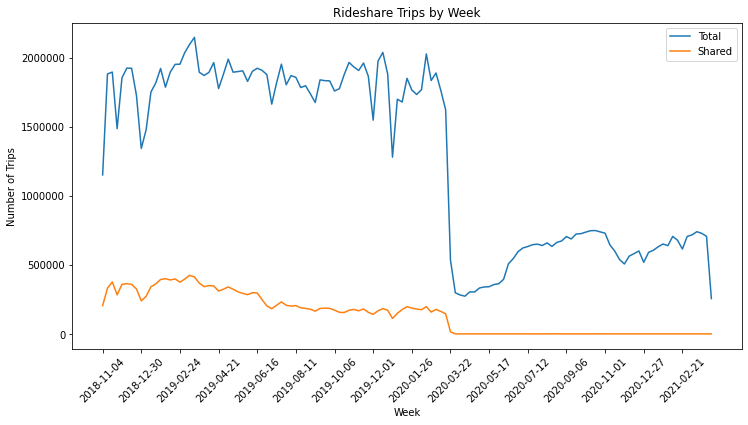

In [68]:
sns.lineplot(data=df_gp, x="week", y="n_trips", label="Total")
sns.lineplot(data=df_gp, x="week", y="n_trips_pooled", label="Shared")
plt.title("Rideshare Trips by Week")
plt.xlabel("Week")
plt.ylabel("Number of Trips")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(np.arange(0, len(df_gp), 8), rotation=45)
plt.gcf().set_size_inches(12, 6)
plt.show()

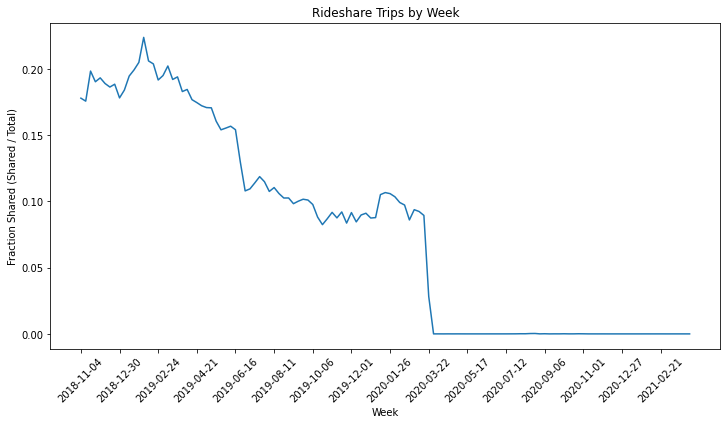

In [69]:
sns.lineplot(data=df_gp, x="week", y="frac_shared")
plt.title("Rideshare Trips by Week")
plt.xlabel("Week")
plt.ylabel("Fraction Shared (Shared / Total)")
plt.xticks(np.arange(0, len(df_gp), 8), rotation=45)
plt.gcf().set_size_inches(12, 6)
plt.show()

In [8]:
df_gp_area = df_rideshare.groupby(["week", "pickup_community_area"])[["n_trips", "n_trips_pooled"]].sum()
df_gp_area = df_gp_area.reset_index().sort_values(by="week", ascending=True)
df_gp_area["frac_shared"] = df_gp_area["n_trips_pooled"] / df_gp_area["n_trips"]
df_gp_area.head()

,week,pickup_community_area,n_trips,n_trips_pooled,frac_shared
0,2018-11-04,1,11886,2435,0.204863
55,2018-11-04,56,10850,1270,0.117051
54,2018-11-04,55,181,21,0.116022
53,2018-11-04,54,417,110,0.263789
52,2018-11-04,53,1641,347,0.211456


In [26]:
df_gp_area \
    .groupby("pickup_community_area")["frac_shared"] \
    .mean() \
    .reset_index() \
    .sort_values(by="frac_shared")

,pickup_community_area,frac_shared
8,9,0.033217
73,74,0.041659
75,76,0.044719
9,10,0.050843
7,8,0.051112
...,...,...
35,36,0.162283
66,67,0.164036
39,40,0.167782
25,26,0.167883


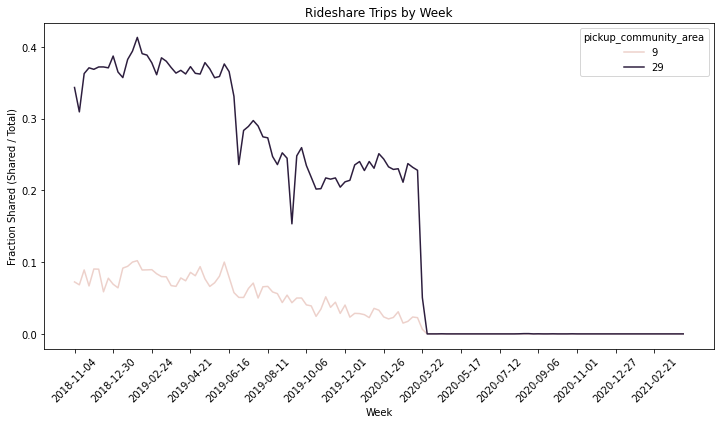

In [28]:
d = df_gp_area.query("pickup_community_area in (9, 29)")
sns.lineplot(data=d, x="week", y="frac_shared", hue="pickup_community_area")
plt.title("Rideshare Trips by Week")
plt.xlabel("Week")
plt.ylabel("Fraction Shared (Shared / Total)")
plt.xticks(np.arange(0, len(df_gp), 8), rotation=45)
plt.gcf().set_size_inches(12, 6)
plt.show()